In [1]:
# -*- coding: utf-8 -*-
"""
Swin Transformer + Tabular Spatio-Temporal Energy Prediction
COMPLETE VERSION - Fixed and Ready to Run!
"""

import os
import pandas as pd
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomRotation, RandomHorizontalFlip
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import cv2
import warnings
import matplotlib.pyplot as plt

try:
    import timm
    print("✅ timm library loaded successfully!")
except ImportError:
    print("❌ timm not found. Please install: pip install timm")
    raise

warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")
print(f"📦 timm version: {timm.__version__}")


class TabularEncoder(nn.Module):
    """Clean tabular encoder - NO DATA LEAKAGE"""
    def __init__(self, num_features=6, output_dim=512, dropout=0.3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = x.float()
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        return self.encoder(x)


class FusionLayer(nn.Module):
    """Simple concatenation + MLP fusion"""
    def __init__(self, vision_dim=512, tabular_dim=512, output_dim=512, dropout=0.3):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(vision_dim + tabular_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, vision_feat, tabular_feat):
        combined = torch.cat([vision_feat, tabular_feat], dim=-1)
        return self.fusion(combined)


class SpatioTemporalSwinModel(nn.Module):
    """
    Spatio-Temporal Swin Transformer + Tabular Model
    
    Architecture:
    1. Swin Transformer (pretrained) → extracts spatial features from each frame
    2. Vision Projection → projects to 512-dim
    3. Temporal Encoder (LSTM/Transformer/GRU) → learns temporal patterns
    4. Tabular Encoder → encodes metadata
    5. Fusion Layer → combines spatio-temporal + tabular
    6. Prediction Head → final output
    """
    def __init__(self,
                 swin_variant='swin_tiny_patch4_window7_224',
                 num_tabular_features=6,
                 sequence_length=6,
                 temporal_method='lstm',
                 dropout=0.3,
                 pretrained=True):
        super().__init__()
        
        self.sequence_length = sequence_length
        self.temporal_method = temporal_method
        
        print(f"\n🔨 Building Spatio-Temporal Model...")
        print(f"   Vision: {swin_variant}")
        print(f"   Temporal method: {temporal_method}")
        print(f"   Sequence length: {sequence_length} timesteps")
        print(f"   Tabular features: {num_tabular_features}")
        
        # 1. Swin Transformer (shared across all frames)
        self.swin = timm.create_model(
            swin_variant,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            in_chans=1,
            img_size=64
        )
        
        swin_out_dim = self.swin.num_features
        print(f"   Swin output dim: {swin_out_dim}")
        
        # 2. Vision projection (per-frame)
        self.vision_proj = nn.Sequential(
            nn.Linear(swin_out_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 3. Temporal encoder
        if temporal_method == 'lstm':
            self.temporal_encoder = nn.LSTM(
                input_size=512,
                hidden_size=512,
                num_layers=2,
                batch_first=True,
                dropout=dropout if dropout > 0 else 0,
                bidirectional=False
            )
            temporal_out_dim = 512
            print(f"   Temporal: 2-layer LSTM (512-dim)")
            
        elif temporal_method == 'gru':
            self.temporal_encoder = nn.GRU(
                input_size=512,
                hidden_size=512,
                num_layers=2,
                batch_first=True,
                dropout=dropout if dropout > 0 else 0,
                bidirectional=False
            )
            temporal_out_dim = 512
            print(f"   Temporal: 2-layer GRU (512-dim)")
            
        elif temporal_method == 'transformer':
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=512,
                nhead=8,
                dim_feedforward=2048,
                dropout=dropout,
                batch_first=True
            )
            self.temporal_encoder = nn.TransformerEncoder(
                encoder_layer,
                num_layers=3
            )
            # Learnable positional encoding
            self.pos_encoding = nn.Parameter(
                torch.randn(1, sequence_length, 512) * 0.02
            )
            temporal_out_dim = 512
            print(f"   Temporal: 3-layer Transformer (8 heads)")
        
        # 4. Tabular encoder
        self.tabular_encoder = TabularEncoder(
            num_features=num_tabular_features,
            output_dim=512,
            dropout=dropout
        )
        
        # 5. Fusion layer
        self.fusion = FusionLayer(
            vision_dim=temporal_out_dim,
            tabular_dim=512,
            output_dim=512,
            dropout=dropout
        )
        
        # 6. Prediction head
        self.head = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"   ✅ Model built! Total params: {total_params/1e6:.2f}M")
    
    def freeze_backbone(self):
        """Freeze ONLY Swin backbone"""
        for p in self.swin.parameters():
            p.requires_grad = False
        print("   🔒 Swin backbone frozen")
    
    def unfreeze_all(self):
        """Unfreeze everything"""
        for p in self.parameters():
            p.requires_grad = True
        print("   🔓 All parameters unfrozen")
    
    def forward(self, img_sequence, tabular):
        """
        Args:
            img_sequence: (B, T, 1, 64, 64) - temporal sequence of images
            tabular: (B, 6) - metadata for target timestep
        Returns:
            predictions: (B, 1)
        """
        batch_size, seq_len = img_sequence.shape[0], img_sequence.shape[1]
        
        # Extract spatial features for each frame
        # Reshape: (B, T, 1, 64, 64) -> (B*T, 1, 64, 64)
        imgs_flat = img_sequence.reshape(batch_size * seq_len, 1, 64, 64)
        
        # Process all frames through Swin (shared weights)
        spatial_features = self.swin(imgs_flat)
        spatial_features = self.vision_proj(spatial_features)
        
        # Reshape back to sequence: (B*T, 512) -> (B, T, 512)
        spatial_sequence = spatial_features.reshape(batch_size, seq_len, 512)
        
        # Temporal encoding
        if self.temporal_method in ['lstm', 'gru']:
            temporal_out, _ = self.temporal_encoder(spatial_sequence)
            temporal_features = temporal_out[:, -1, :]
            
        elif self.temporal_method == 'transformer':
            spatial_sequence = spatial_sequence + self.pos_encoding[:, :seq_len, :]
            temporal_out = self.temporal_encoder(spatial_sequence)
            temporal_features = temporal_out[:, -1, :]
        
        # Encode tabular features
        tabular_feat = self.tabular_encoder(tabular)
        
        # Fuse spatio-temporal and tabular
        fused = self.fusion(temporal_features, tabular_feat)
        
        # Final prediction
        output = self.head(fused)
        
        return output


class AddNoise:
    def __init__(self, std=0.01):
        self.std = std
    def __call__(self, x):
        return x + torch.randn_like(x) * self.std


class SpatioTemporalDataset(Dataset):
    """Dataset with pre-built temporal sequences"""
    def __init__(self, image_sequences, features, targets=None, augment=False):
        self.image_sequences = torch.FloatTensor(image_sequences)
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets) if targets is not None else None
        self.augment = augment
        
        if augment:
            self.transforms = transforms.Compose([
                RandomRotation(10),
                RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([AddNoise(0.01)], p=0.3)
            ])
    
    def __len__(self):
        return len(self.image_sequences)
    
    def __getitem__(self, idx):
        seq = self.image_sequences[idx]
        seq = seq.unsqueeze(1)
        
        if self.augment and self.transforms:
            augmented_frames = []
            for t in range(seq.shape[0]):
                frame = self.transforms(seq[t])
                augmented_frames.append(frame)
            seq = torch.stack(augmented_frames)
        
        if self.targets is not None:
            return seq, self.features[idx], self.targets[idx]
        return seq, self.features[idx]


def load_spatiotemporal_data(csv_path, image_dir, sequence_length=6):
    """Load data and build temporal sequences"""
    print("\n" + "="*80)
    print("📊 LOADING SPATIO-TEMPORAL DATA (PRE-BUILT SEQUENCES)")
    print("="*80)
    
    df = pd.read_csv(csv_path)
    df = df[(df['Energy Use per Capita (kWh)'] > 0) & 
            (df['Population'] > 0) & 
            (df['Area (Sq. Km)'] > 0)]
    
    df['date'] = pd.to_datetime(df['Date (month/year)'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df = df.sort_values(['Country', 'date']).reset_index(drop=True)
    
    print(f"\n📋 Dataset info:")
    print(f"   Total rows: {len(df)}")
    print(f"   Countries: {df['Country'].nunique()}")
    print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
    
    # Feature engineering
    for col in ['Population', 'Area (Sq. Km)']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    df['log_population'] = np.log1p(df['Population'].astype(float))
    df['log_area'] = np.log1p(df['Area (Sq. Km)'].astype(float))
    df['density'] = df['Population'].astype(float) / (df['Area (Sq. Km)'].astype(float) + 1)
    df['log_density'] = np.log1p(df['density'])
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(float) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(float) / 12)
    year_min, year_max = df['year'].min(), df['year'].max()
    df['year_normalized'] = (df['year'].astype(float) - year_min) / (year_max - year_min + 1e-8)
    
    df = df.fillna(0)
    
    feature_cols = [
        'log_population', 'log_area', 'log_density',
        'month_sin', 'month_cos', 'year_normalized'
    ]
    
    print(f"\n🔧 Features: {', '.join(feature_cols)}")
    
    # Step 1: Load ALL images
    print(f"\n🖼️ Step 1: Loading all images...")
    images_dict = {}
    
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['Country'],
                                f"{row['Country']}_{row['year']}_{row['month']:02d}.png")
        
        if os.path.exists(img_path):
            try:
                with rasterio.open(img_path) as src:
                    image = src.read(1)
                    if image is None or np.isnan(image).any() or np.isinf(image).any():
                        continue
                    
                    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
                    key = (row['Country'], row['year'], row['month'])
                    images_dict[key] = image
                    
            except Exception:
                continue
    
    print(f"   ✅ Loaded {len(images_dict)} images into memory")
    
    # Step 2: Global normalization
    print(f"\n📐 Step 2: Computing global normalization...")
    all_pixels = np.concatenate([img.flatten() for img in images_dict.values()])
    global_min, global_max = np.percentile(all_pixels, 1), np.percentile(all_pixels, 99)
    print(f"   Min (1st percentile): {global_min:.2f}")
    print(f"   Max (99th percentile): {global_max:.2f}")
    
    # Normalize all images
    for key in images_dict:
        img = images_dict[key]
        norm_img = np.clip((img - global_min) / (global_max - global_min + 1e-8), 0, 1)
        norm_img = np.nan_to_num(norm_img, nan=0.0, posinf=1.0, neginf=0.0)
        images_dict[key] = norm_img.astype(np.float32)
    
    # Step 3: Build temporal sequences
    print(f"\n⏱️ Step 3: Building temporal sequences (length={sequence_length})...")
    
    image_sequences = []
    features_list = []
    targets_list = []
    years_list = []
    skipped_no_history = 0
    skipped_missing_images = 0
    
    for idx, row in df.iterrows():
        country = row['Country']
        target_date = row['date']
        
        # Get country's historical data
        country_df = df[df['Country'] == country]
        past_data = country_df[country_df['date'] < target_date].tail(sequence_length)
        
        # Skip if not enough history
        if len(past_data) < sequence_length:
            skipped_no_history += 1
            continue
        
        # Build sequence of images
        sequence_images = []
        sequence_valid = True
        
        for _, past_row in past_data.iterrows():
            key = (past_row['Country'], past_row['year'], past_row['month'])
            
            if key not in images_dict:
                sequence_valid = False
                break
            
            sequence_images.append(images_dict[key])
        
        if not sequence_valid:
            skipped_missing_images += 1
            continue
        
        # Validate features and target
        feature_vals = [float(row[col]) for col in feature_cols]
        if any(np.isnan(v) or np.isinf(v) for v in feature_vals):
            continue
        
        target_val = row['Energy Use per Capita (kWh)']
        if np.isnan(target_val) or np.isinf(target_val) or target_val <= 0:
            continue
        
        # All valid - add to lists
        image_sequences.append(np.stack(sequence_images))
        features_list.append(feature_vals)
        targets_list.append([target_val])
        years_list.append(row['year'])
    
    print(f"\n📊 Sequence Building Summary:")
    print(f"   ✅ Valid sequences: {len(image_sequences)}")
    print(f"   ⚠️ Skipped (insufficient history): {skipped_no_history}")
    print(f"   ⚠️ Skipped (missing images): {skipped_missing_images}")
    
    if len(image_sequences) == 0:
        raise ValueError("No valid sequences created! Check your data.")
    
    # Convert to arrays
    image_sequences = np.stack(image_sequences)
    features = np.array(features_list)
    targets = np.array(targets_list)
    years = np.array(years_list)
    
    print(f"\n✅ Final Data Shapes:")
    print(f"   Image sequences: {image_sequences.shape}")
    print(f"   Features: {features.shape}")
    print(f"   Targets: {targets.shape}")
    print(f"   Years: {years.shape}")
    
    # Log-transform targets
    print(f"\n📊 Target transformation:")
    print(f"   Original range: [{targets.min():.2f}, {targets.max():.2f}] kWh")
    targets_log = np.log1p(targets)
    print(f"   Log-transformed range: [{targets_log.min():.2f}, {targets_log.max():.2f}]")
    
    return image_sequences, features, targets_log, years


def evaluate_model(model, loader, device, target_scaler):
    """Evaluation for spatio-temporal model"""
    model.eval()
    preds_scaled_log, targets_scaled_log = [], []
    
    with torch.no_grad():
        for batch in loader:
            img_seqs, feats, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            outputs = model(img_seqs, feats)
            
            preds_scaled_log.append(outputs.cpu().numpy())
            targets_scaled_log.append(labels.cpu().numpy())
    
    preds_scaled_log = np.concatenate(preds_scaled_log).ravel()
    targets_scaled_log = np.concatenate(targets_scaled_log).ravel()
    
    preds_log = target_scaler.inverse_transform(preds_scaled_log.reshape(-1, 1)).ravel()
    targets_log = target_scaler.inverse_transform(targets_scaled_log.reshape(-1, 1)).ravel()
    
    preds_orig = np.expm1(preds_log)
    targets_orig = np.expm1(targets_log)
    preds_orig = np.maximum(preds_orig, 0.0)
    
    mae_orig = mean_absolute_error(targets_orig, preds_orig)
    rmse_orig = np.sqrt(mean_squared_error(targets_orig, preds_orig))
    r2_orig = r2_score(targets_orig, preds_orig)
    pearson_r, _ = pearsonr(targets_orig, preds_orig)
    
    epsilon = 1e-8
    errors = np.abs((targets_orig - preds_orig) / (targets_orig + epsilon)) * 100
    mape = np.mean(np.clip(errors, 0, 300))
    wape = (np.sum(np.abs(targets_orig - preds_orig)) / (np.sum(np.abs(targets_orig)) + epsilon)) * 100
    smape = np.mean(200 * np.abs(targets_orig - preds_orig) / (np.abs(targets_orig) + np.abs(preds_orig) + epsilon))
    within_5 = np.mean(errors <= 5) * 100
    within_10 = np.mean(errors <= 10) * 100
    
    mae_scaled_log = mean_absolute_error(targets_scaled_log, preds_scaled_log)
    
    return {
        'loss_scaled_log': mae_scaled_log,
        'mae': mae_orig,
        'rmse': rmse_orig,
        'mape': mape,
        'wape': wape,
        'smape': smape,
        'r2': r2_orig,
        'pearson_r': pearson_r,
        'within_5': within_5,
        'within_10': within_10
    }


def train_spatiotemporal_model(image_sequences, features, targets, years, device,
                                swin_variant='swin_tiny_patch4_window7_224',
                                sequence_length=6,
                                temporal_method='lstm',
                                pretrained=True):
    """Train spatio-temporal model with 2-phase strategy"""
    
    # Time series split
    train_mask = years <= 2020
    val_mask = (years > 2020) & (years <= 2022)
    test_mask = years > 2022
    
    print(f"\n📊 Time Series Split:")
    print(f"   Train (≤2020): {train_mask.sum()} samples")
    print(f"   Val (2021-2022): {val_mask.sum()} samples")
    print(f"   Test (>2022): {test_mask.sum()} samples")
    
    # Scaling
    feat_scaler = RobustScaler()
    targ_scaler = RobustScaler()
    
    train_feat = feat_scaler.fit_transform(features[train_mask])
    train_targ = targ_scaler.fit_transform(targets[train_mask])
    val_feat = feat_scaler.transform(features[val_mask])
    val_targ = targ_scaler.transform(targets[val_mask])
    test_feat = feat_scaler.transform(features[test_mask])
    test_targ = targ_scaler.transform(targets[test_mask])
    
    # Datasets
    train_ds = SpatioTemporalDataset(
        image_sequences[train_mask], train_feat, train_targ, augment=True
    )
    val_ds = SpatioTemporalDataset(
        image_sequences[val_mask], val_feat, val_targ
    )
    test_ds = SpatioTemporalDataset(
        image_sequences[test_mask], test_feat, test_targ
    )
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True)
    
    # Model
    print("\n🔨 Building spatio-temporal model...")
    model = SpatioTemporalSwinModel(
        swin_variant=swin_variant,
        num_tabular_features=6,
        sequence_length=sequence_length,
        temporal_method=temporal_method,
        dropout=0.5,
        pretrained=pretrained
    )
    
    model = model.to(device)
    criterion = nn.L1Loss()
    
    # ===================== PHASE 1: FREEZE BACKBONE =====================
    warmup_epochs = 15
    print(f"\n{'='*80}")
    print(f"🔒 PHASE 1: FREEZE SWIN BACKBONE ONLY")
    print(f"{'='*80}")
    print(f"Duration: {warmup_epochs} epochs")
    print(f"Training: Vision Projection + Temporal + Tabular + Fusion + Head")
    
    model.freeze_backbone()
    
    for p in model.vision_proj.parameters():
        p.requires_grad = True
    
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    trainable_count = sum(p.numel() for p in trainable_params)
    print(f"\n📊 Phase 1 Trainable: {trainable_count/1e6:.2f}M params")
    
    optimizer_phase1 = optim.AdamW(trainable_params, lr=5e-4, weight_decay=1e-4)
    scheduler_phase1 = CosineAnnealingLR(optimizer_phase1, T_max=warmup_epochs, eta_min=1e-6)
    
    best_wape_phase1 = float('inf')
    
    for epoch in range(warmup_epochs):
        model.train()
        total_loss = 0
        
        for img_seqs, feats, labels in train_loader:
            img_seqs = img_seqs.to(device)
            feats = feats.to(device)
            labels = labels.to(device)
            
            optimizer_phase1.zero_grad()
            outputs = model(img_seqs, feats)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
            optimizer_phase1.step()
            
            total_loss += loss.item()
        
        train_loss_avg = total_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, targ_scaler)
        scheduler_phase1.step()
        
        print(f"[P1] Epoch {epoch+1:2d}/{warmup_epochs}: "
              f"TrLoss={train_loss_avg:.4f} | "
              f"ValLoss={val_metrics['loss_scaled_log']:.4f} | "
              f"WAPE={val_metrics['wape']:5.2f}% | "
              f"R²={val_metrics['r2']:.4f}")
        
        if val_metrics['wape'] < best_wape_phase1:
            best_wape_phase1 = val_metrics['wape']
    
    print(f"\n✅ Phase 1 Complete! Best WAPE: {best_wape_phase1:.2f}%")
    
    # ===================== PHASE 2: UNFREEZE ALL =====================
    print(f"\n{'='*80}")
    print(f"🔓 PHASE 2: UNFREEZE ALL - 6-GROUP OPTIMIZER")
    print(f"{'='*80}")
    
    model.unfreeze_all()
    
    # Organize parameters into groups
    swin_params = []
    vision_proj_params = []
    temporal_params = []
    tabular_params = []
    fusion_head_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        
        if any(k in name.lower() for k in ('bias', 'ln', 'layernorm', 'norm')):
            no_decay_params.append(param)
        elif name.startswith('swin'):
            swin_params.append(param)
        elif name.startswith('vision_proj'):
            vision_proj_params.append(param)
        elif name.startswith('temporal') or name.startswith('pos_encoding'):
            temporal_params.append(param)
        elif name.startswith('tabular'):
            tabular_params.append(param)
        else:
            fusion_head_params.append(param)
    
    print(f"\n📊 Parameter Groups:")
    print(f"   Group 1 (Swin): {len(swin_params)} params, LR=1e-5")
    print(f"   Group 2 (Vision Proj): {len(vision_proj_params)} params, LR=5e-5")
    print(f"   Group 3 (Temporal): {len(temporal_params)} params, LR=5e-4")
    print(f"   Group 4 (Tabular): {len(tabular_params)} params, LR=5e-4")
    print(f"   Group 5 (Fusion+Head): {len(fusion_head_params)} params, LR=5e-4")
    print(f"   Group 6 (No Decay): {len(no_decay_params)} params, LR=5e-4, WD=0")
    
    optimizer_phase2 = optim.AdamW([
        {'params': swin_params, 'lr': 1e-5, 'weight_decay': 0.05},
        {'params': vision_proj_params, 'lr': 5e-5, 'weight_decay': 0.05},
        {'params': temporal_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': tabular_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': fusion_head_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': no_decay_params, 'lr': 5e-4, 'weight_decay': 0.0}
    ])
    
    warmup_phase2_epochs = 5
    
    def lr_lambda(epoch):
        if epoch < warmup_phase2_epochs:
            return (epoch + 1) / warmup_phase2_epochs
        return 1.0
    
    warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer_phase2, lr_lambda)
    
    plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_phase2,
        mode='min',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        threshold=0.01,
        threshold_mode='rel'
    )
    
    print(f"\n🚀 Training Strategy (ADAPTIVE):")
    print(f"   - Warmup: {warmup_phase2_epochs} epochs")
    print(f"   - Adaptive: ReduceLROnPlateau (patience=10)")
    print(f"   - Early stopping: patience=50 on WAPE")
    
    best_wape = float('inf')
    patience = 50
    epochs_no_improve = 0
    
    history = {
        'train_loss': [], 'val_loss': [], 'val_mape': [],
        'val_wape': [], 'val_r2': [], 'learning_rate': []
    }
    
    for epoch in range(200):
        model.train()
        total_loss = 0
        
        for img_seqs, feats, labels in train_loader:
            img_seqs = img_seqs.to(device)
            feats = feats.to(device)
            labels = labels.to(device)
            
            optimizer_phase2.zero_grad()
            outputs = model(img_seqs, feats)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer_phase2.step()
            
            total_loss += loss.item()
        
        train_loss_avg = total_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, targ_scaler)
        
        # Adaptive scheduler logic
        if epoch < warmup_phase2_epochs:
            warmup_scheduler.step()
            current_lr = optimizer_phase2.param_groups[0]['lr']
        else:
            old_lr = optimizer_phase2.param_groups[0]['lr']
            plateau_scheduler.step(val_metrics['wape'])
            current_lr = optimizer_phase2.param_groups[0]['lr']
            
            if current_lr != old_lr:
                print(f"\n    📉 LR Reduced: {old_lr:.2e} → {current_lr:.2e} (Plateau detected)\n")
        
        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_metrics['loss_scaled_log'])
        history['val_mape'].append(val_metrics['mape'])
        history['val_wape'].append(val_metrics['wape'])
        history['val_r2'].append(val_metrics['r2'])
        history['learning_rate'].append(current_lr)
        
        warmup_tag = "[WARMUP]" if epoch < warmup_phase2_epochs else "[ADAPTIVE]"
        
        print(f"[P2] Epoch {epoch+1:3d} {warmup_tag}: "
              f"TrLoss={train_loss_avg:.4f} | "
              f"ValLoss={val_metrics['loss_scaled_log']:.4f} | "
              f"MAPE={val_metrics['mape']:5.2f}% | "
              f"WAPE={val_metrics['wape']:5.2f}% ⭐ | "
              f"R²={val_metrics['r2']:.4f} | "
              f"LR={current_lr:.2e}")
        
        if val_metrics['wape'] < best_wape:
            best_wape = val_metrics['wape']
            epochs_no_improve = 0
            
            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'wape': val_metrics['wape'],
                'mape': val_metrics['mape'],
                'r2': val_metrics['r2'],
                'feat_scaler': feat_scaler,
                'targ_scaler': targ_scaler
            }, 'best_spatiotemporal_model.pt')
            
            print(f"    💾 Best model saved: WAPE={val_metrics['wape']:.2f}%")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"\n⏹ Early stopping at epoch {epoch+1}")
            print(f"   Best WAPE: {best_wape:.2f}%")
            break
    
    # ===================== TEST EVALUATION =====================
    print("\n" + "="*80)
    print("🎯 TEST SET EVALUATION")
    print("="*80)
    
    checkpoint = torch.load('best_spatiotemporal_model.pt', weights_only=False)
    model.load_state_dict(checkpoint['model'])
    
    test_metrics = evaluate_model(model, test_loader, device, targ_scaler)
    
    print(f"\n📊 TEST RESULTS:")
    print(f"   WAPE: {test_metrics['wape']:.2f}% ⭐")
    print(f"   MAPE: {test_metrics['mape']:.2f}%")
    print(f"   sMAPE: {test_metrics['smape']:.2f}%")
    print(f"   MAE: {test_metrics['mae']:.2f} kWh")
    print(f"   RMSE: {test_metrics['rmse']:.2f} kWh")
    print(f"   R²: {test_metrics['r2']:.4f}")
    print(f"   Pearson: {test_metrics['pearson_r']:.4f}")
    print(f"   Within ±5%: {test_metrics['within_5']:.1f}%")
    print(f"   Within ±10%: {test_metrics['within_10']:.1f}%")
    
    plot_training_history(history, test_metrics, sequence_length, temporal_method)
    
    return model, feat_scaler, targ_scaler, test_metrics, test_loader


def plot_training_history(history, test_metrics, sequence_length, temporal_method):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'🚀 Spatio-Temporal Swin Training ({temporal_method.upper()})', 
                 fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MAE Loss (log)')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # MAPE vs WAPE
    axes[0, 1].plot(epochs, history['val_mape'], 'g-', label='MAPE', linewidth=2)
    axes[0, 1].plot(epochs, history['val_wape'], 'b-', label='WAPE ⭐', linewidth=2)
    axes[0, 1].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Target 5%')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Error (%)')
    axes[0, 1].set_title('Validation Errors')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # R²
    axes[0, 2].plot(epochs, history['val_r2'], 'm-', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('R² Score')
    axes[0, 2].set_title('Validation R²')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(epochs, history['learning_rate'], 'orange', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Adaptive Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # WAPE progression
    axes[1, 1].plot(epochs, history['val_wape'], 'b-', linewidth=2)
    axes[1, 1].axhline(y=test_metrics['wape'], color='r', linestyle='--', 
                      linewidth=2, label=f"Test: {test_metrics['wape']:.2f}%")
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('WAPE (%)')
    axes[1, 1].set_title('WAPE Progression')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Summary
    axes[1, 2].axis('off')
    summary = f"""
TEST RESULTS (SPATIO-TEMPORAL)

WAPE: {test_metrics['wape']:.2f}%
MAPE: {test_metrics['mape']:.2f}%
R²: {test_metrics['r2']:.4f}
Within ±5%: {test_metrics['within_5']:.1f}%
Within ±10%: {test_metrics['within_10']:.1f}%

Architecture:
- Swin Transformer (spatial)
- {temporal_method.upper()} (temporal)
- Sequence length: {sequence_length}
- Tabular features: 6
- ~30M parameters

Training Strategy:
✅ Phase 1: Freeze Swin backbone
✅ Phase 2: 6-group optimizer
  · Adaptive LR (plateau-based)
  · Early stopping (patience=50)
    """
    axes[1, 2].text(0.05, 0.5, summary, fontsize=9, verticalalignment='center',
                    fontfamily='monospace', 
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    plt.tight_layout()
    plt.savefig('spatiotemporal_training_history.png', dpi=300, bbox_inches='tight')
    print("\n✅ Training plot saved as 'spatiotemporal_training_history.png'")
    plt.show()




c:\Users\FA004\Desktop\satimg2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ timm library loaded successfully!
✅ Libraries loaded successfully!
🔥 PyTorch version: 2.9.0+cu126
🎮 CUDA available: True
📦 timm version: 1.0.21


🚀 SPATIO-TEMPORAL SWIN MODEL
Architecture: Swin (spatial) + LSTM/Transformer (temporal) + Tabular
Temporal Sequences: Pre-built during loading (simple & safe!)

✅ CUDA Device: NVIDIA GeForce RTX 4070 Ti SUPER


📊 LOADING SPATIO-TEMPORAL DATA (PRE-BUILT SEQUENCES)

📋 Dataset info:
   Total rows: 10842
   Countries: 85
   Date range: 2010-01-01 00:00:00 to 2025-02-01 00:00:00

🔧 Features: log_population, log_area, log_density, month_sin, month_cos, year_normalized

🖼️ Step 1: Loading all images...
   ✅ Loaded 10652 images into memory

📐 Step 2: Computing global normalization...
   Min (1st percentile): 0.00
   Max (99th percentile): 73.00

⏱️ Step 3: Building temporal sequences (length=6)...

📊 Sequence Building Summary:
   ✅ Valid sequences: 10332
   ⚠️ Skipped (insufficient history): 510
   ⚠️ Skipped (missing images): 0

✅ Final Data Shapes:
   Image sequences: (10332, 6, 64, 64)
   Features: (10332, 6)
   Targets: (10332, 1)
   Years: (10332,)

📊 Target transformation:
   Original ra

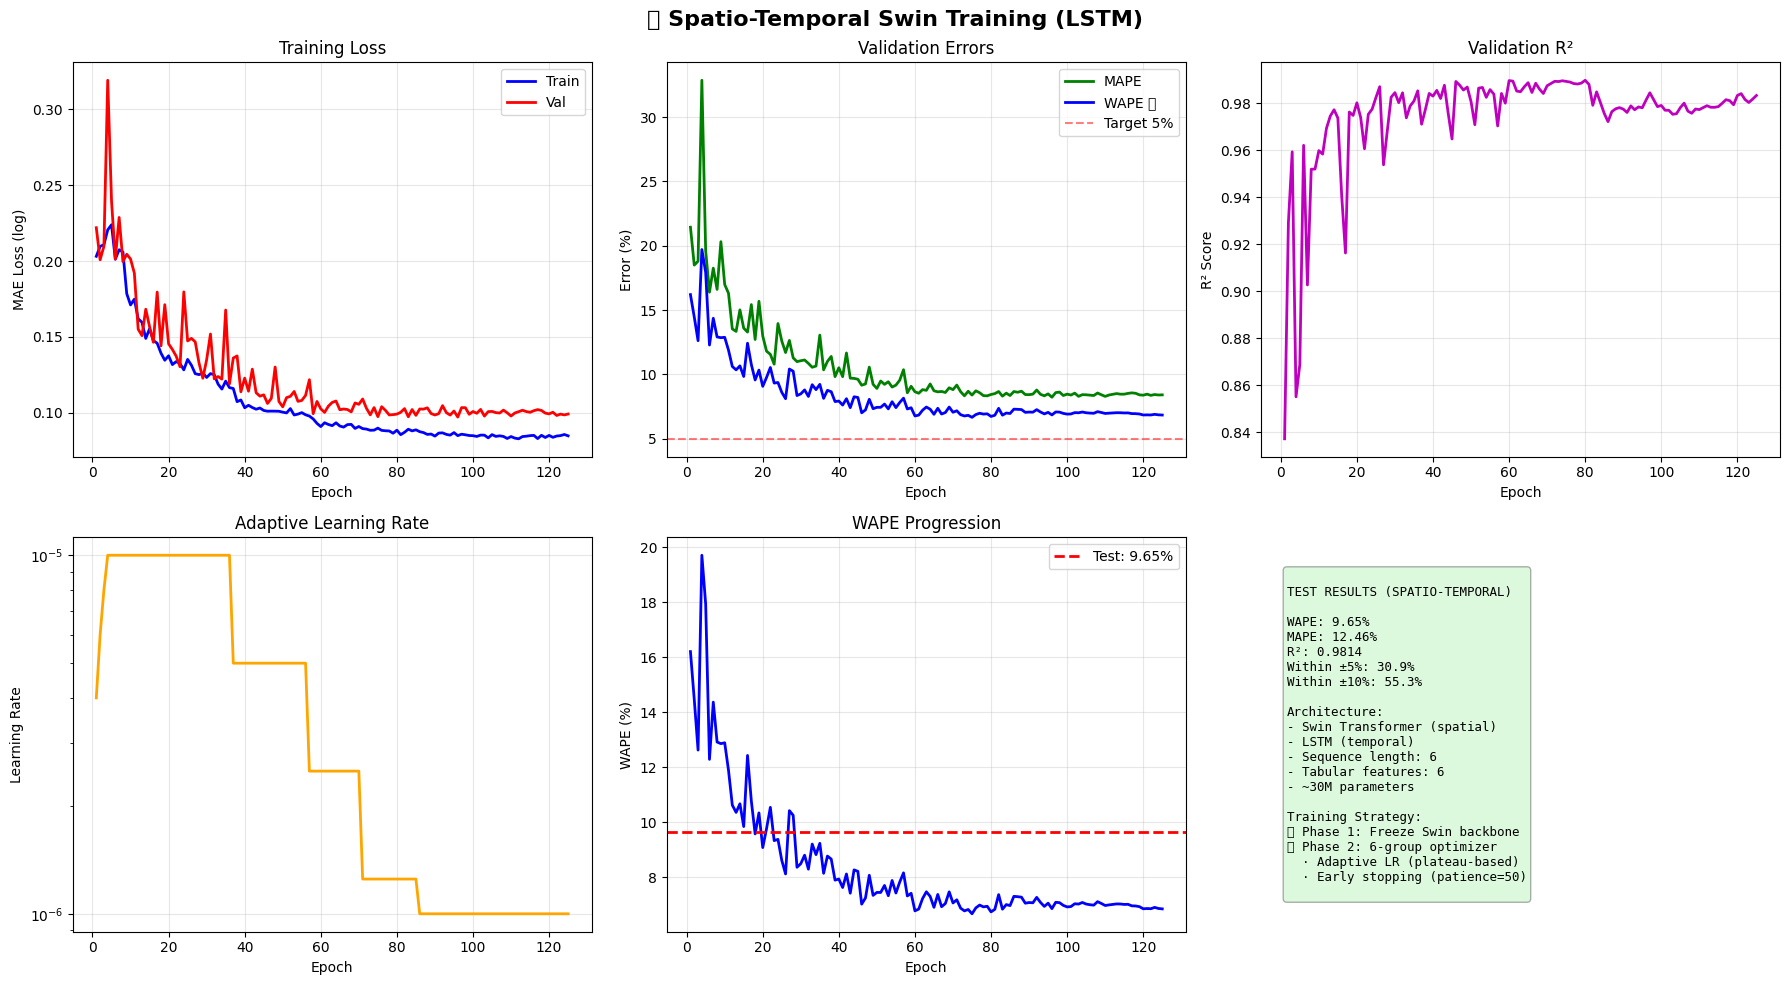


✅ SPATIO-TEMPORAL TRAINING COMPLETE!
🎯 Final Test WAPE: 9.65%
📊 Final Test MAPE: 12.46%
🏆 Model saved as: best_spatiotemporal_model.pt

✨ Temporal method: LSTM
✨ Sequence length: 6 months



In [2]:

print("="*80)
print("🚀 SPATIO-TEMPORAL SWIN MODEL")
print("="*80)
print("Architecture: Swin (spatial) + LSTM/Transformer (temporal) + Tabular")
print("Temporal Sequences: Pre-built during loading (simple & safe!)")
print("="*80 + "\n")

# CUDA cleanup
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"✅ CUDA Device: {torch.cuda.get_device_name(0)}\n")

# Paths
csv_path = 'C:\\Users\\FA004\\Desktop\\satimg21\\data.csv'
image_dir = 'C:\\Users\\FA004\\Desktop\\satimg21\\images_png_view'

# Configuration
sequence_length = 6  # Use past 6 months
temporal_method = 'lstm'  # Options: 'lstm', 'gru', 'transformer'

# Load data with temporal sequences
image_sequences, features, targets, years = load_spatiotemporal_data(
    csv_path, image_dir, sequence_length=sequence_length
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🎮 Device: {device}\n")

# Train spatio-temporal model
model, feat_scaler, targ_scaler, test_metrics, test_loader = train_spatiotemporal_model(
    image_sequences, features, targets, years, device,
    swin_variant='swin_tiny_patch4_window7_224',
    sequence_length=sequence_length,
    temporal_method=temporal_method,
    pretrained=True
)

print("\n" + "="*80)
print("✅ SPATIO-TEMPORAL TRAINING COMPLETE!")
print("="*80)
print(f"🎯 Final Test WAPE: {test_metrics['wape']:.2f}%")
print(f"📊 Final Test MAPE: {test_metrics['mape']:.2f}%")
print(f"🏆 Model saved as: best_spatiotemporal_model.pt")
print(f"\n✨ Temporal method: {temporal_method.upper()}")
print(f"✨ Sequence length: {sequence_length} months")
print("="*80 + "\n")    